# Use the class


In [ ]:
import pennylane as qml
from pennylane import numpy as np
import pandas as pd
import jax
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as mse
from scipy.optimize import minimize
from IPython.display import clear_output
import random 
from pennylane.optimize import AdamOptimizer,QNSPSAOptimizer
from utils import *
import os

from autoencoder3 import Autoencoder_composite

(<Figure size 1300x600 with 1 Axes>, <Axes: >)

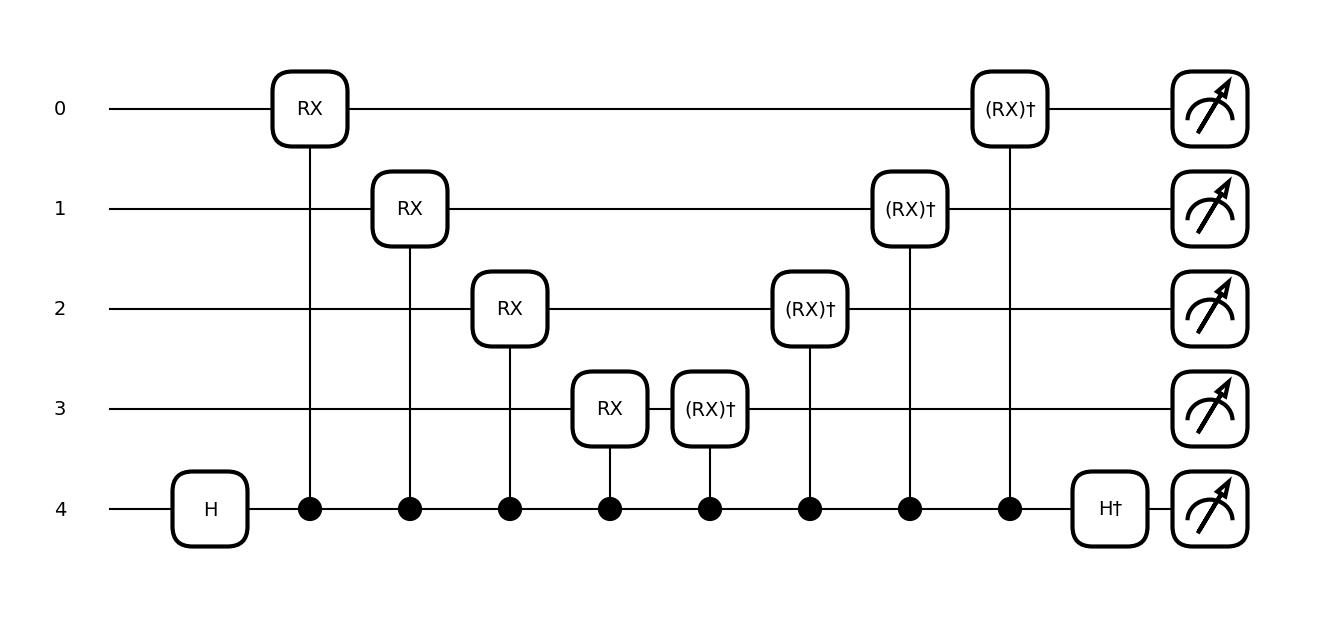

In [97]:
n_qubit = 5
dvc = qml.device('default.mixed', wires=n_qubit, shots=None)
def a():
    qml.Hadamard(dvc.wires[-1])
    for k in dvc.wires[:-1]:
        qml.CRX(np.pi/2,[dvc.wires[-1],k])

@qml.qnode(dvc)
def b():
    a()
    qml.adjoint(a)()
    return qml.state()
qml.draw_mpl(b)()